In [13]:
import torch
import torchvision
from torchvision.utils import make_grid
import torch
import torch.utils.data 
import torch.nn.functional as F

import math
from torch.cuda import amp

from spikingjelly.activation_based import functional
from spikingjelly.datasets import cifar10_dvs

import numpy as np
import argparse
import matplotlib.pyplot as plt

import sys

sys.path.append('./..')

import deepModelsCIFAR10DVS, utils

In [5]:
device = torch.device('cuda:0')

In [6]:
def split_to_train_test_set(train_ratio: float, origin_dataset: torch.utils.data.Dataset, num_classes: int, random_split: bool = False):
    '''
    :param train_ratio: split the ratio of the origin dataset as the train set
    :type train_ratio: float
    :param origin_dataset: the origin dataset
    :type origin_dataset: torch.utils.data.Dataset
    :param num_classes: total classes number, e.g., ``10`` for the MNIST dataset
    :type num_classes: int
    :param random_split: If ``False``, the front ratio of samples in each classes will
            be included in train set, while the reset will be included in test set.
            If ``True``, this function will split samples in each classes randomly. The randomness is controlled by
            ``numpy.randon.seed``
    :type random_split: int
    :return: a tuple ``(train_set, test_set)``
    :rtype: tuple
    '''
    label_idx = []
    for i in range(num_classes):
        label_idx.append([])

    for i, item in enumerate(origin_dataset):
        y = item[1]
        if isinstance(y, np.ndarray) or isinstance(y, torch.Tensor):
            y = y.item()
        label_idx[y].append(i)
    train_idx = []
    test_idx = []
    if random_split:
        for i in range(num_classes):
            np.random.shuffle(label_idx[i])

    for i in range(num_classes):
        pos = math.ceil(label_idx[i].__len__() * train_ratio)
        train_idx.extend(label_idx[i][0: pos])
        test_idx.extend(label_idx[i][pos: label_idx[i].__len__()])

    return torch.utils.data.Subset(origin_dataset, train_idx), torch.utils.data.Subset(origin_dataset, test_idx)


In [8]:
origin_set = cifar10_dvs.CIFAR10DVS(root='./../datasets/CIFAR10DVS', data_type='frame', frames_number=16, split_by='number')

train_set, test_set = split_to_train_test_set(0.9, origin_set, 10)

The directory [./../datasets/CIFAR10DVS/frames_number_16_split_by_number] already exists.


In [9]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    pin_memory=True)



In [11]:
net = deepModelsCIFAR10DVS.__dict__['SEWResNet']('ADD')
net.to(device)

path = '/home/shihao/ProjectDiego/code/logs/posterLogs/CIFAR10DVS/CIFAR10DVS_SEWResNet_ADD_T_16_T_train_None_SGD_lr_0.01_CosALR_64_amp_pt/checkpoint_max.pth'
optimizer = torch.optim.SGD(net.parameters(), 0.01, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

checkpoint = torch.load(path, map_location='cpu')
net.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
start_epoch = checkpoint['epoch'] + 1
max_test_acc = checkpoint['max_test_acc']
print("Model created")
print(max_test_acc)

Model created
0.705


In [16]:
from random import randint

def showImage(x, label):
    # x.shape: 4, 16, 2, 128, 128
    # x, label = train_set_CIFAR10DVS[0] # 16, 2, 128, 128 example

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    to_img = torchvision.transforms.ToPILImage()
    img_tensor = torch.zeros([x.shape[0], x.shape[1], 3, x.shape[3], x.shape[4]])
    img_tensor[:, :, 1] = x[:, :, 0]
    img_tensor[:, :, 2] = x[:, :, 1]

    #img_list = []
    tensor_list = []
    for t in range(img_tensor.shape[0]):
        #for k in range(img_tensor.shape[1]):
            #ext= img_tensor[t,k]
            #print(ext.shape)
        #    tensor_list.append(img_tensor[t,k])
        #img_list.append(to_img(img_tensor[t]))
        k = randint(0,15)
        tensor_list.append(img_tensor[t,k])
    #print(len(tensor_list))
    imgP = to_img(make_grid(tensor_list, nrow=1))


    fig = plt.figure(frameon=False)
    fig.set_size_inches(3,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(imgP, aspect='auto')
    #fig.savefig("./../images/airplane.svg", dpi=300)

    print(label)
    plt.show()

    return fig

tensor([0, 0, 4, 0], device='cuda:0')


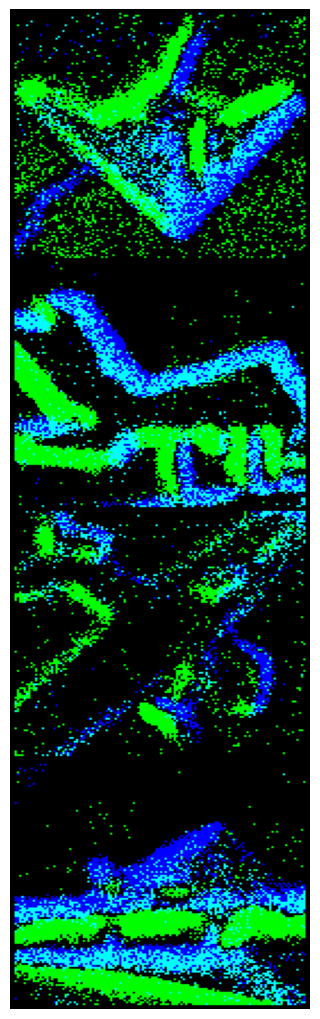

tensor([1, 9, 9, 1], device='cuda:0')


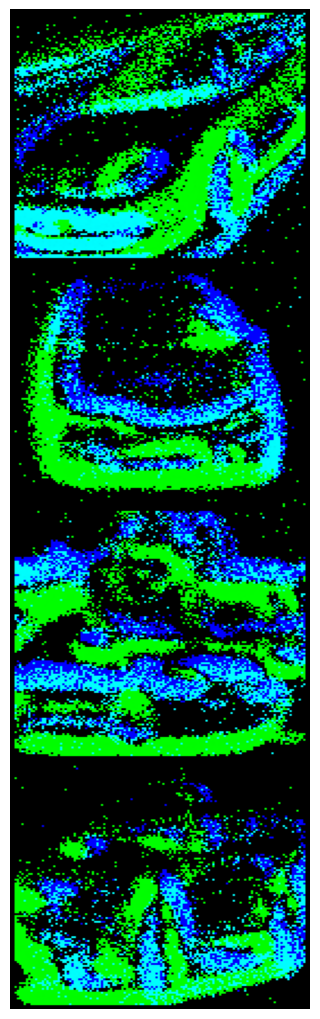

tensor([2, 2, 2, 2], device='cuda:0')


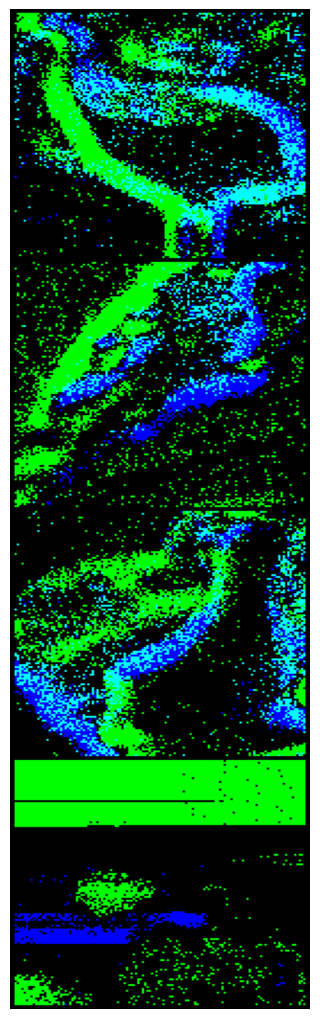

tensor([6, 3, 5, 5], device='cuda:0')


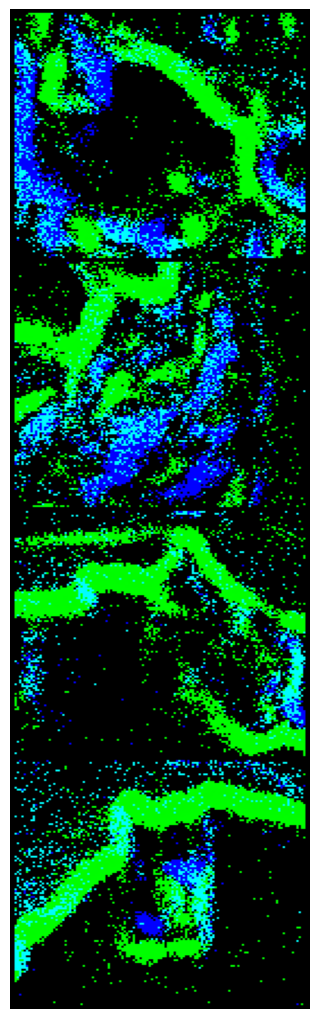

tensor([4, 4, 4, 4], device='cuda:0')


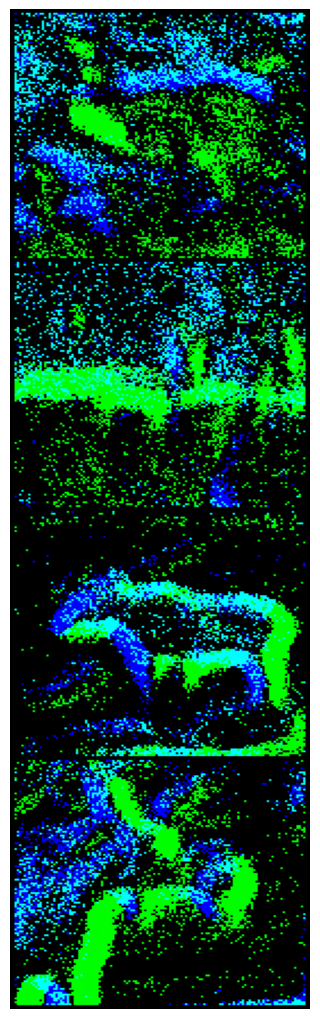

tensor([5, 5, 5, 3], device='cuda:0')


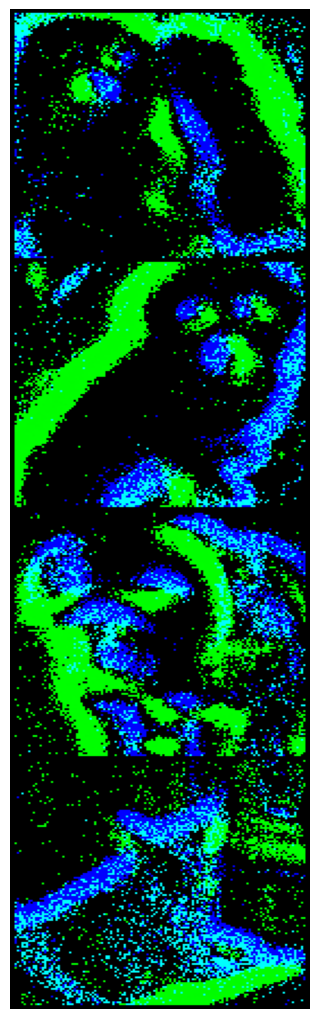

tensor([3, 6, 3, 6], device='cuda:0')


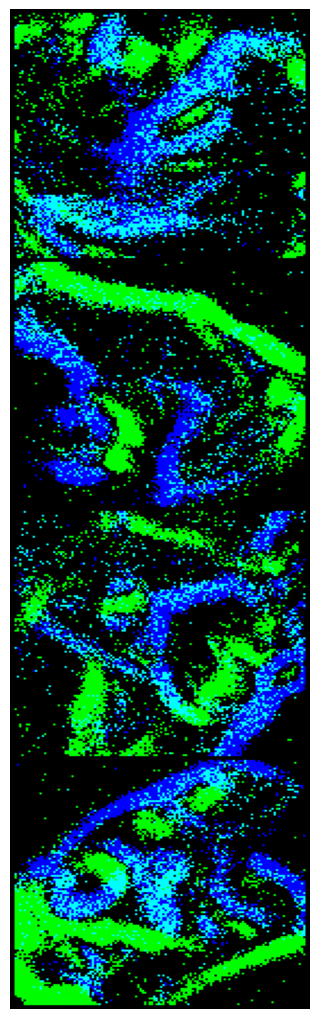

tensor([5, 7, 7, 5], device='cuda:0')


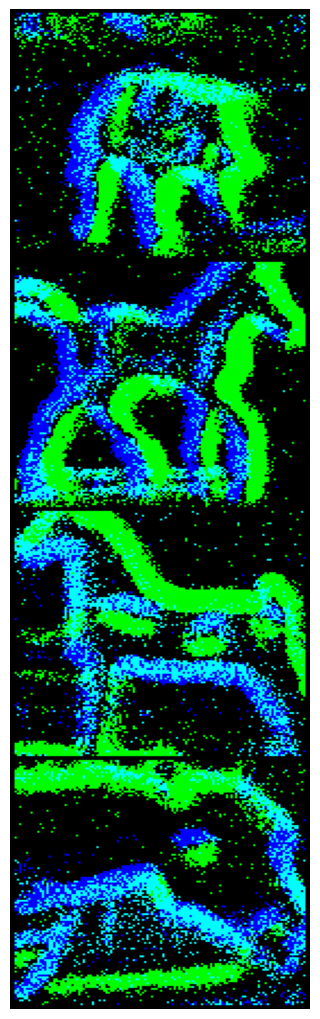

tensor([8, 8, 8, 8], device='cuda:0')


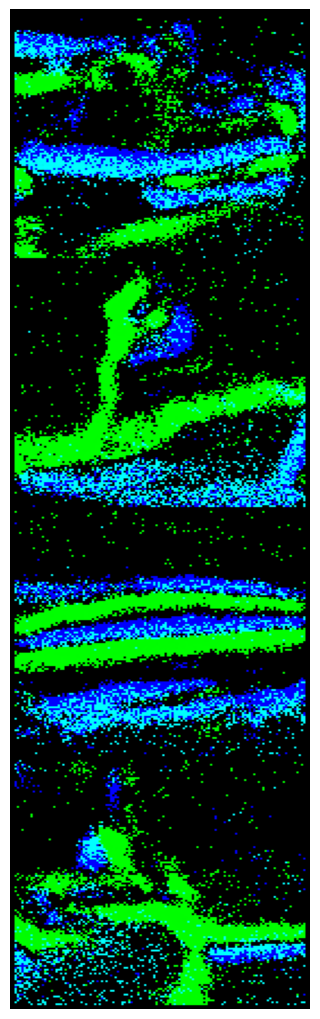

tensor([9, 9, 9, 9], device='cuda:0')


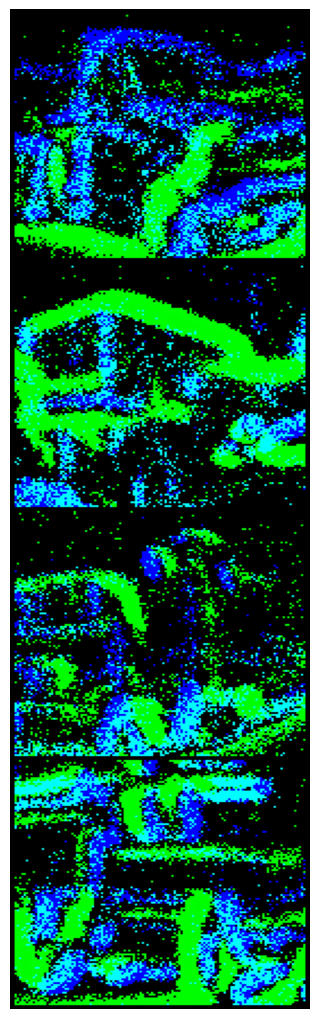

test_loss=1.2448246512794867, test_acc=0.725, max_test_acc=0.705


In [21]:
net.eval()
test_loss = 0
test_acc = 0
test_samples = 0
with torch.no_grad():
    i = 0
    for frame, label in test_data_loader:
        if label[0]== i:
            frame = frame.float().to(device)
            label = label.to(device)
            
            out_fr = net(frame)
            loss = F.cross_entropy(out_fr, label)

            pred = out_fr.argmax(1)          
            
            fig = showImage(frame, pred)
            strPred = str(pred)
            name = strPred[7:19] + str(i) +"vert_CF10"
            fig.savefig("./../images/"+name+".svg", dpi=300)
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)

            i += 1

            if i == 10:
                break
test_loss /= test_samples
test_acc /= test_samples


print(f'test_loss={test_loss}, test_acc={test_acc}, max_test_acc={max_test_acc}')
